In [2]:
# Libraries
import pandas as pd

dataset = pd.read_csv("./datasets/heart_data.csv")
dataset.drop(columns=['index', 'id'], axis=1, inplace=True)


# Preparing data

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

y = dataset['cardio'].values
cardio = dataset.drop(['cardio'], axis=1)
cat_attribs = ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active']
cardio_num = cardio.drop(cat_attribs, axis=1)
num_attribs = list(cardio_num)

num_pipeline = Pipeline([('std_scaler', StandardScaler())])
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs), #num_pipeline
 ("cat", OneHotEncoder(), cat_attribs), #one hot encoder
 ])
cardio_prepared = full_pipeline.fit_transform(cardio)

# Split into train and test set

In [4]:
from sklearn.model_selection import train_test_split

y = dataset['cardio'].values
X = cardio_prepared.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binary Classifier

In [5]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

# Validating Training Set

In [6]:
# cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.7166122 , 0.71548722, 0.72511518])

In [31]:
#confusing matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

#-> |a b |   |TN FP|
#-> |c d |   |FN TP|
# Binary classifier, first row is the negative class and the second row is the positive class
# a = true negatives (TN) - correctly classified as negative class
# b = false positives (FP)- wrongly classified as positive class
# c = false negative (FN)- wrongly classified as negative class
# d = true positive (TP) - correctly classified as positive class

array([[22395,  5638],
       [10094, 17873]], dtype=int64)

In [30]:
#precision (accuracy of the positive preditions) =  TP / (TP + FP)
#recall (sensitivity or True Positive Rate TPR, ratio of positive instances that are corretly detected) = TP / (TP + FN)
#f1-score (harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high f1 score, if both recall and precision are high)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("f1: ", f1)

Precision:  0.7601973544298414
Recall:  0.6390746236636036
f1:  0.6943937215898053


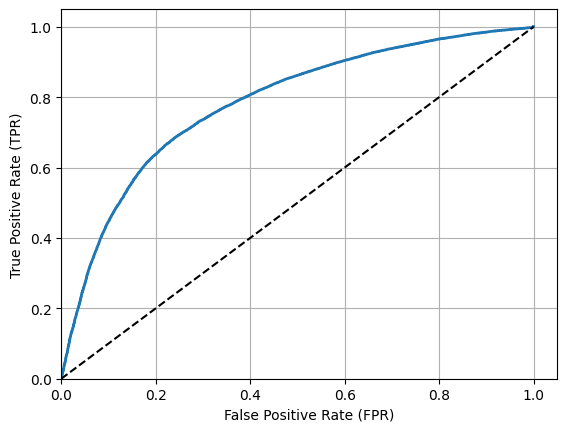

AUC:  0.7833060695412114


In [28]:
#ROC CURVE
#true positive rate x false positive rate (FPR)
#FPR is the ratio of negative instances that are incorrectly classified as positive
#FPR = 1 - true negative ratio (TNR or specificity : ratio of negative instances that are correctly classified as negative)
#Hence, ROC curve plots sensitivity (recall) x 1 - specificity
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.grid(visible=None, which='major', axis='both')
    plt.ylim(ymin=0)  # this line
    plt.xlim(xmin=0)  # this line
plot_roc_curve(fpr, tpr)
plt.show()


from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_scores)
print("AUC: ", auc)

#ROC CURVE X Precision/Recall (PR)
# PR -> when the positive class is rare or care more about false positives than false negatives


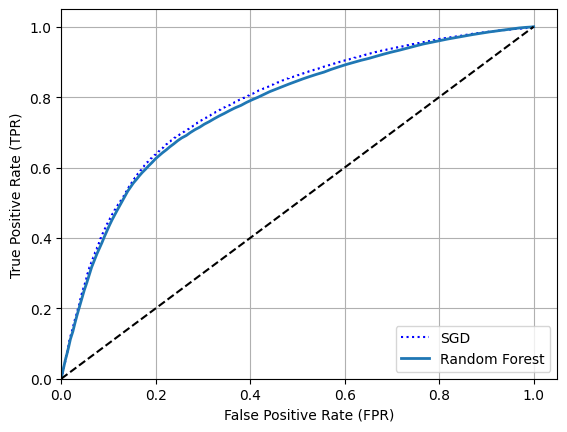

In [37]:
#RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()